In [3]:
import random
import shapely
import pointpats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import time
from scipy.optimize import differential_evolution
import random
from scipy.optimize import dual_annealing

In [4]:
# parameters / constant
NUM_LEO = 1
NUM_HAP = 1
NUM_UAV = 2
NUM_IOT = 10

UAV_Z_MIN = 1_000
UAV_Z_MAX = 2_000
Min_distance = 200


HAP_Z_MIN = 20_000
HAP_Z_MAX = 25_000

LEO_Z = 340_000
CELL_R = 2_000
r_min = 1

AWGN_DBM = -174
AWGN_MW = 10 ** (AWGN_DBM / 10)
AWGN_W = AWGN_MW / 1000
AWGN_W

P_LEO_MIN = 0.1
P_LEO_MAX = 1

P_HAP_MIN = 0.1
P_HAP_MAX = 1

P_UAV_1_MIN = 00.1
P_UAV_1_MAX = 1

P_UAV_2_MIN = 0.1
P_UAV_2_MAX = 1

R_MIN = 5


B = 3 * 1e6
F_LEO = 15 * 1e9
C = 3e8  # [m/s]
LEO_XYZ = np.array([0, 0, LEO_Z]).astype(float)

iot_xyz = np.array(
    [
        [1011, 1066, 0],
        [231, 1584, 0],
        [161, -1386, 0],
        [-452, -1690, 0],
        [1099, 1002, 0],
        [-1824, 67, 0],
        [630, 629, 0],
        [1363, 1085, 0],
        [648, 905, 0],
        [665, 678, 0],
    ]
).astype(float)

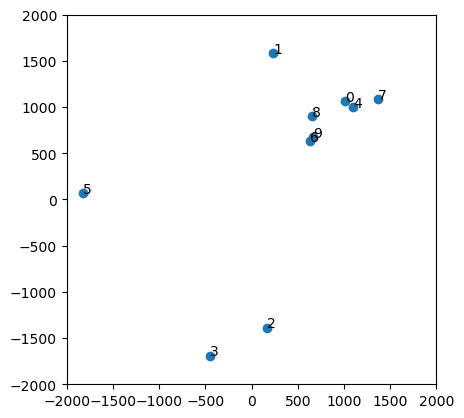

In [4]:
fig, ax = plt.subplots()

ax.scatter(iot_xyz[:, 0], iot_xyz[:, 1])
for i in range(10):
    ax.annotate(str(i), (iot_xyz[i, 0], iot_xyz[i, 1]))

ax.set_xlim(-2000, 2000)
ax.set_ylim(-2000, 2000)
ax.set_aspect('equal')

---

Objective function


In [5]:
def obj_function(
    hap_xyz=np.array([0, 0, HAP_Z_MAX]),
    uav_xyz=np.array([[0, 0, UAV_Z_MAX], [0, 0, UAV_Z_MAX]]),
    p_leo=1,
    p_hap=1,
    p_uav1=1,
    p_uav2=1,
    b_s=0.5,
    b_h=0.1,
    b_u1=0.2,
    b_u2=0.2,
    iot_select_leo=[5],
    iot_select_hap=[3, 2],
    iot_select_uav1=[1, 8, 6, 9],
    iot_select_uav2=[0, 4, 7],
    iot_uav1_hap=[],
    iot_uav2_hap=[],
):
    LEO_HAP = np.sqrt((LEO_XYZ[0] - hap_xyz[0]) ** 2 + (LEO_XYZ[1] - hap_xyz[1]) ** 2 + (LEO_XYZ[2] - hap_xyz[2]) ** 2)
    LEO_UAV1 = np.sqrt((LEO_XYZ[0] - uav_xyz[0, 0]) ** 2 + (LEO_XYZ[1] - uav_xyz[0, 1]) ** 2 + (LEO_XYZ[2] - uav_xyz[0, 2]) ** 2)
    LEO_UAV2 = np.sqrt((LEO_XYZ[0] - uav_xyz[1, 0]) ** 2 + (LEO_XYZ[1] - uav_xyz[1, 0]) ** 2 + (LEO_XYZ[2] - uav_xyz[1, 0]) ** 2)
    LEO_IOT = np.sqrt((LEO_XYZ[0] - iot_xyz[:, 0]) ** 2 + (LEO_XYZ[1] - iot_xyz[:, 1]) ** 2 + (LEO_XYZ[2] - iot_xyz[:, 2]) ** 2)

    HAP_UAV1 = np.sqrt((hap_xyz[0] - uav_xyz[0, 0]) ** 2 + (hap_xyz[1] - uav_xyz[0, 1]) ** 2 + (hap_xyz[2] - uav_xyz[0, 2]) ** 2)
    HAP_UAV2 = np.sqrt((hap_xyz[0] - uav_xyz[1, 0]) ** 2 + (hap_xyz[1] - uav_xyz[1, 1]) ** 2 + (hap_xyz[2] - uav_xyz[1, 2]) ** 2)
    HAP_IOT = np.sqrt((hap_xyz[0] - iot_xyz[:, 0]) ** 2 + (hap_xyz[1] - iot_xyz[:, 1]) ** 2 + (hap_xyz[2] - iot_xyz[:, 2]) ** 2)

    UAV1_IOT = np.sqrt((uav_xyz[0, 0] - iot_xyz[:, 0]) ** 2 + (uav_xyz[0, 1] - iot_xyz[:, 1]) ** 2 + (uav_xyz[0, 2] - iot_xyz[:, 2]) ** 2)
    UAV2_IOT = np.sqrt((uav_xyz[1, 0] - iot_xyz[:, 0]) ** 2 + (uav_xyz[1, 1] - iot_xyz[:, 1]) ** 2 + (uav_xyz[1, 2] - iot_xyz[:, 2]) ** 2)
    UAV1_UAV2 = np.sqrt((uav_xyz[0, 0] - uav_xyz[1, 0]) ** 2 + (uav_xyz[0, 1] - uav_xyz[1, 1]) ** 2 + (uav_xyz[0, 2] - uav_xyz[1, 2]) ** 2)

    # pathloss (unitless)
    pl_leo_hap = (C / (4 * np.pi * F_LEO * LEO_HAP)) ** 2
    pl_leo_uav1 = (C / (4 * np.pi * F_LEO * LEO_UAV1)) ** 2
    pl_leo_uav2 = (C / (4 * np.pi * F_LEO * LEO_UAV2)) ** 2
    pl_leo_iot = (C / (4 * np.pi * F_LEO * LEO_IOT)) ** 2
    pl_hap_uav1 = (C / (4 * np.pi * F_LEO * HAP_UAV1)) ** 2
    pl_hap_uav2 = (C / (4 * np.pi * F_LEO * HAP_UAV2)) ** 2
    pl_hap_iot = (C / (4 * np.pi * F_LEO * HAP_IOT)) ** 2
    pl_uav1_iot = (C / (4 * np.pi * F_LEO * UAV1_IOT)) ** 2
    pl_uav2_iot = (C / (4 * np.pi * F_LEO * UAV2_IOT)) ** 2

    # SNR from LEO (unitless)
    snr_leo_hap = p_leo * pl_leo_hap / AWGN_W
    snr_leo_uav1 = p_leo * pl_leo_uav1 / AWGN_W
    snr_leo_uav2 = p_leo * pl_leo_uav2 / AWGN_W
    snr_leo_iot = p_leo * pl_leo_iot / AWGN_W

    # SNR from HAP (unitless)
    snr_hap_uav1 = p_hap * pl_hap_uav1 / AWGN_W
    snr_hap_uav2 = p_hap * pl_hap_uav2 / AWGN_W
    snr_hap_iot = p_hap * pl_hap_iot / AWGN_W

    # SNR from UAV (unitless)
    snr_uav1_iot = p_uav1 * pl_uav1_iot / AWGN_W
    snr_uav2_iot = p_uav2 * pl_uav2_iot / AWGN_W

    # Data rate from leo
    dr_bps_leo_hap = b_s * B * np.log2(1 + snr_leo_hap)
    dr_bps_leo_uav1 = b_s * B * np.log2(1 + snr_leo_uav1)
    dr_bps_leo_uav2 = b_s * B * np.log2(1 + snr_leo_uav2)
    dr_bps_leo_iot = b_s * B * np.log2(1 + snr_leo_iot)

    dr_mbps_leo_hap = dr_bps_leo_hap / 1e6
    # print(f"==>> dr_mbps_leo_hap: {dr_mbps_leo_hap}")
    dr_mbps_leo_uav1 = dr_bps_leo_uav1 / 1e6
    print(f"==>> dr_mbps_leo_uav1: {dr_mbps_leo_uav1}")
    dr_mbps_leo_uav2 = dr_bps_leo_uav2 / 1e6
    # print(f"==>> dr_mbps_leo_uav2: {dr_mbps_leo_uav2}")
    dr_mbps_leo_iot = dr_bps_leo_iot / 1e6
    # print(f"==>> dr_mbps_leo_iot: {dr_mbps_leo_iot}")

    # Data rate from hap
    dr_bps_hap_uav1 = b_h * B * np.log2(1 + snr_hap_uav1)
    dr_bps_hap_uav2 = b_h * B * np.log2(1 + snr_hap_uav2)
    dr_bps_hap_iot = b_h * B * np.log2(1 + snr_hap_iot)  # wrong 1
    dr_mbps_hap_uav1 = dr_bps_hap_uav1 / 1e6
    # print(f"==>> dr_mbps_hap_uav1: {dr_mbps_hap_uav1}")
    dr_mbps_hap_uav2 = dr_bps_hap_uav2 / 1e6
    # print(f"==>> dr_mbps_hap_uav2: {dr_mbps_hap_uav2}")
    dr_mbps_hap_iot = dr_bps_hap_iot / 1e6
    # print(f"==>> dr_mbps_hap_iot: {dr_mbps_hap_iot}")

    # Data rate from uav1
    dr_bps_uav1_iot = b_u1 * B * np.log2(1 + snr_uav1_iot)
    dr_mbps_uav1_iot = dr_bps_uav1_iot / 1e6
    print(f"==>> dr_mbps_uav1_iot: {dr_mbps_uav1_iot}")


    # Data rate from uav2
    dr_bps_uav2_iot = b_u2 * B * np.log2(1 + snr_uav2_iot)
    dr_mbps_uav2_iot = dr_bps_uav2_iot / 1e6
    # print(f"==>> dr_mbps_uav2_iot: {dr_mbps_uav2_iot}")

    # link selection: leo_iot
    dr_iot_leo = dr_mbps_leo_iot[iot_select_leo]
    # print(f"==>> dr_iot_leo: {dr_iot_leo}")
    
    
    # test link selection: leo_hap_iot
    iot_hap = dr_mbps_hap_iot[iot_select_hap]
    # iot_hap_element = np.size(iot_hap)
    dr_iot_hap = np.minimum(iot_hap, dr_mbps_leo_hap)
    # print(f"==>> dr_iot_hap: {dr_iot_hap}")
    

    # link selection: leo_uav1_iot
    iot_uav1 = dr_mbps_uav1_iot[iot_select_uav1]
    dr_iot_uav1 = np.minimum(iot_uav1, dr_mbps_leo_uav1)
    # print(f"==>> dr_iot_uav1: {dr_iot_uav1}")
    

    # link selection: leo_uav2_iot
    iot_uav2 = dr_mbps_uav2_iot[iot_select_uav2]
    dr_iot_uav2 = np.minimum(iot_uav2, dr_mbps_leo_uav2)
    # print(f"==>> dr_iot_uav2: {dr_iot_uav2}")
    
    # link selection: leo_hap_uav1_iot
    iot_uav1 = dr_mbps_uav1_iot[iot_uav1_hap]
    dr_uav1_hap = np.minimum(dr_mbps_hap_uav1, dr_mbps_leo_hap)  # wrong2
    dr_iot_uav1_hap = np.minimum(iot_uav1, dr_uav1_hap)
    

    # link selection: leo_hap_uav2_iot
    iot_uav2 = dr_mbps_uav2_iot[iot_uav2_hap]
    dr_uav2_hap = np.minimum(dr_mbps_hap_uav2, dr_mbps_leo_hap)  # wrong3
    dr_iot_uav2_hap = np.minimum(iot_uav2, dr_uav2_hap)
    

    iot_data_rate = [
        *dr_iot_leo,
        *dr_iot_hap,
        *dr_iot_uav1,
        *dr_iot_uav2,
        *dr_iot_uav1_hap,
        *dr_iot_uav2_hap,
    ]

    # print(f"==>> iot_data_rate: {iot_data_rate}")

    dr_iot_system = sum(iot_data_rate)

    if np.min(iot_data_rate) < R_MIN:
        return 0
    else:
        return dr_iot_system


obj_function()

==>> dr_mbps_leo_uav1: 18.6653401088557
==>> dr_mbps_uav1_iot: [15.9734918  15.9184996  16.0037508  15.85518552 15.96602844 15.82257506
 16.1905615  15.85830645 16.11347282 16.17102974]


142.80208732856693

In [6]:
def obj_f1(x):
    return -obj_function(hap_xyz=np.array([x[0], x[1], HAP_Z_MAX]), uav_xyz=np.array([[x[2], x[3], UAV_Z_MAX], [x[4], x[5], UAV_Z_MAX]]))

# x = np.array([0, 1, 2, 3, 4, 5])
# obj_f1(x)

In [7]:
bounds = [(-2000, 2000), (-2000, 2000), (-2000, 2000), (-2000, 2000), (-2000, 2000), (-2000, 2000)]

result = dual_annealing(obj_f1, bounds, maxiter=1000)
print(result.x)
print(result.fun)

==>> dr_mbps_leo_hap: 18.970233450473255
==>> dr_iot_hap: [5.98529412 5.98649151]
==>> iot_data_rate: [18.63974786731124, 5.985294120944867, 5.986491506469006, 15.837360931282694, 15.707234368576623, 15.704604894582687, 15.692591851767592, 15.040658956575696, 15.030198744369514, 14.938681487438823]
==>> dr_mbps_leo_hap: 18.970150037729745
==>> dr_iot_hap: [5.98332246 5.98493834]
==>> iot_data_rate: [18.63974786731124, 5.98332246435326, 5.984938342164988, 15.565603978409412, 15.487084943785948, 15.507332605155451, 15.491326738933681, 15.35903445156608, 15.391490890891879, 15.372708833655173]
==>> dr_mbps_leo_hap: 18.970158229741248
==>> dr_iot_hap: [5.9750377  5.97799179]
==>> iot_data_rate: [18.63974786731124, 5.975037704642438, 5.977991788338658, 15.506665152422062, 15.844241415175512, 15.920168206605563, 15.917664756902138, 16.316576134517234, 16.297277383838725, 16.254916958373972]
==>> dr_mbps_leo_hap: 18.970293729677007
==>> dr_iot_hap: [5.98590566 5.98604975]
==>> iot_data_rate: 

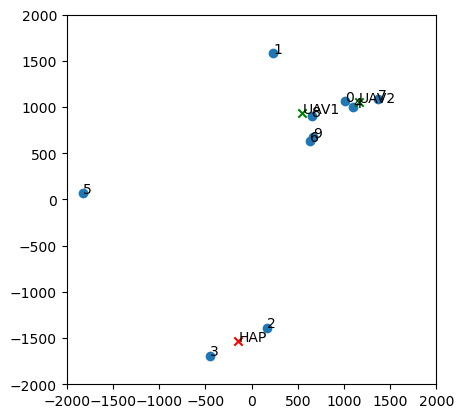

In [8]:
fig, ax = plt.subplots()

ax.scatter(iot_xyz[:, 0], iot_xyz[:, 1])
for i in range(10):
    ax.annotate(str(i), (iot_xyz[i, 0], iot_xyz[i, 1]))

ax.scatter(result.x[0], result.x[1], c='r', marker='x')
ax.annotate('HAP', (result.x[0], result.x[1]))
ax.scatter(result.x[2], result.x[3], c='g', marker='x')
ax.annotate('UAV1', (result.x[2], result.x[3]))
ax.scatter(result.x[4], result.x[5], c='g', marker='x')
ax.annotate('UAV2', (result.x[4], result.x[5]))


ax.set_xlim(-2000, 2000)
ax.set_ylim(-2000, 2000)
ax.set_aspect('equal')

In [9]:
f_opt = -result.fun
f_opt

144.88096001290543

In [10]:
x_opt = result.x
x_opt

array([ -143.8975361 , -1529.46480852,   548.9830079 ,   935.1056316 ,
        1159.05292566,  1052.74036757])

In [11]:
obj_function(hap_xyz=np.array([x_opt[0], x_opt[1], HAP_Z_MAX]), uav_xyz=np.array([[x_opt[2], x_opt[3], UAV_Z_MAX], [x_opt[4], x_opt[5], UAV_Z_MAX]]))

==>> dr_mbps_leo_hap: 18.97025182827773
==>> dr_iot_hap: [5.98712111 5.98712607]
==>> iot_data_rate: [18.63974786731124, 5.987121114732391, 5.987126067910563, 16.24082546821667, 16.344721215830873, 16.325605794267528, 16.329987137624077, 16.34226756277162, 16.34569941309657, 16.33785837114387]


144.88096001290543

In [20]:
def obj_f_bandwidth(x):
    y = np.sort(x)
    xx = np.array([y[0], y[1] - y[0], y[2] - y[1], 1 - y[2]])
    
    return -obj_function(
        hap_xyz=np.array([x_opt[0], x_opt[1], HAP_Z_MAX]),
        uav_xyz=np.array([[x_opt[2], x_opt[3], UAV_Z_MAX], [x_opt[4], x_opt[5], UAV_Z_MAX]]),
        b_s=xx[0],
        b_h=xx[1],
        b_u1=xx[2],
        b_u2=xx[3],
    )


obj_f_bandwidth(np.array([0.1, 0.2, 0.3]))

==>> dr_mbps_leo_uav1: 3.7330635681071724
==>> dr_mbps_uav1_iot: [8.14926001 8.12041273 7.79740913 7.70190042 8.14151363 7.76060354
 8.1628029  8.10509477 8.17236061 8.16499357]


0

In [21]:
bounds = [(0, 1), (0, 1), (0, 1)]

result = dual_annealing(obj_f_bandwidth, bounds, maxiter=1000)

==>> dr_mbps_leo_uav1: 15.72940253624645
==>> dr_mbps_uav1_iot: [4.13736774 4.12272202 3.95873355 3.91024391 4.13343492 3.9400474
 4.14424345 4.11494511 4.14909588 4.14535565]
==>> dr_mbps_leo_uav1: 17.597800455162442
==>> dr_mbps_uav1_iot: [4.13736713 4.12272141 3.95873297 3.91024334 4.13343431 3.94004682
 4.14424284 4.11494451 4.14909527 4.14535504]
==>> dr_mbps_leo_uav1: 4.633834680478216
==>> dr_mbps_uav1_iot: [39.2806871  39.1416388  37.58471173 37.12434506 39.24334838 37.40730313
 39.34596591 39.06780386 39.39203555 39.35652529]
==>> dr_mbps_leo_uav1: 20.242110293516266
==>> dr_mbps_uav1_iot: [4.13736713 4.12272141 3.95873297 3.91024334 4.13343431 3.94004682
 4.14424284 4.11494451 4.14909527 4.14535504]
==>> dr_mbps_leo_uav1: 20.242110293516266
==>> dr_mbps_uav1_iot: [5.83262064 5.81197396 5.58079254 5.51243467 5.82707638 5.5544499
 5.84231361 5.80101052 5.84915429 5.84388153]
==>> dr_mbps_leo_uav1: 20.242110293516266
==>> dr_mbps_uav1_iot: [8.55413044 8.52384998 8.18479895 8.084

In [14]:
f_opt_bw = result.fun
f_opt_bw

-152.85389895762523

In [22]:
y = np.sort(result.x)
x_opt_bw = np.array([y[0] - 0, y[1] - y[0], y[2] - y[1], 1 - y[2]])
x_opt_bw

array([0.4788366 , 0.08351417, 0.21902517, 0.21862406])

In [ ]:
obj_function(
        hap_xyz=np.array([x_opt[0], x_opt[1], HAP_Z_MAX]),
        uav_xyz=np.array([[x_opt[2], x_opt[3], UAV_Z_MAX], [x_opt[4], x_opt[5], UAV_Z_MAX]]),
        b_s=x_opt_bw[0],
        b_h=x_opt_bw[1],
        b_u1=x_opt_bw[2],
        b_u2=x_opt_bw[3],
)